# **FC**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/semester_project_2.3/mit-bih-atrial-fibrillation-database-1.0.0.zip'
!cp "{zip_path}" /content/afdb.zip
!mkdir -p afdb_data
!unzip -q /content/afdb.zip -d afdb_data
!pip install wfdb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace afdb_data/files/08455.hea? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import os
import zipfile
import random
import numpy as np
import wfdb
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Create included patients list

In [4]:
# patient records are in data_dir
data_dir = "/content/afdb_data/files"
all_files = os.listdir(data_dir)

# patients with .dat files
dat_files = [f for f in all_files if f.endswith('.dat')]
dat_patients = sorted([f.replace('.dat', '') for f in dat_files])

# after inspection in other notebooks, these are the excluded patients
excluded_patients = ['00735', '03665', '04043', '08405', '08434', '07859']

# final included patients list
included_patients = sorted([p for p in dat_patients if p not in excluded_patients])

print(f"Total included patients: {len(included_patients)}")
print(included_patients)

Total included patients: 19
['04015', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07879', '07910', '08215', '08219', '08378', '08455']


#### Make sure all of our patients contain AFib labels

In [5]:
# making sure all of our patients have AFib windows
# and aren't strictly AFL/J patients
print("Confirming all patients have AFib windows\n")

patient_has_af = {}
for rec in included_patients:
    path = os.path.join(data_dir, rec)
    ann = wfdb.rdann(path, 'atr')
    # if patient has one AFib window, mark them as AFib
    has_af = any('(AFIB' in s for s in ann.aux_note)
    patient_has_af[rec] = int(has_af)

# create lists
af_patients = [p for p, v in patient_has_af.items() if v == 1]
non_af_patients = [p for p, v in patient_has_af.items() if v == 0]

# print results
print(f"Total patients with AFIB episodes: {len(af_patients)}")
print(af_patients)
print(f"\nTotal patients without AFIB episodes: {len(non_af_patients)}")
print(non_af_patients)

Confirming all patients have AFib windows

Total patients with AFIB episodes: 19
['04015', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07879', '07910', '08215', '08219', '08378', '08455']

Total patients without AFIB episodes: 0
[]


#### Split into test and val sets

In [9]:
# reproducibility
random.seed(42)
random.shuffle(af_patients)

# 80-20 train/val split
# based only on af_patients since they all belong there
split_af = int(0.8 * len(af_patients))

train_patients = af_patients[:split_af]
val_patients   = af_patients[split_af:]

random.shuffle(train_patients)
random.shuffle(val_patients)

# print final splits
print("Patient split summary:")
print(f"Total train patients: {len(train_patients)}")
print(f"Total val patients: {len(val_patients)}\n")
print(f"Train patients:\n{train_patients}")
print(f"Val patients:\n{val_patients}")

Patient split summary:
Total train patients: 15
Total val patients: 4

Train patients:
['05261', '04048', '05121', '04126', '08455', '04936', '08215', '08378', '04908', '04015', '04746', '06453', '07879', '08219', '06995']
Val patients:
['06426', '05091', '07162', '07910']


#### Apply per-window preprocessing

In [10]:
# initialize constants and arrays
FS = 250
WINDOW_SECONDS = 10
WINDOW_SIZE = WINDOW_SECONDS * FS
STEP_SIZE = WINDOW_SIZE // 2  # 50% overlap between windows
total_windows = 0
dropped_windows = 0

X_train, y_train = [], []
X_val, y_val = [], []

print("Starting window preprocessing")
for rec in tqdm(included_patients):
    # get signal
    path = os.path.join(data_dir, rec)
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path, 'atr')
    signal = record.p_signal
    ann_samples = ann.sample
    ann_symbols = ann.aux_note

    # create mask, N:0 - AFib:1
    label_mask = np.full(len(signal), -1, dtype=np.int8)
    current_label = -1
    for i, (sample, label) in enumerate(zip(ann_samples, ann_symbols)):
        if '(AFIB' in label:
            current_label = 1
        elif '(N' in label:
            current_label = 0
        else:
            current_label = -1
        # fill out
        end = ann_samples[i + 1] if i < len(ann_samples) - 1 else len(signal)
        label_mask[sample:end] = current_label

    # slide windows across the signal to extract segments
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        end = start + WINDOW_SIZE
        seg_labels = label_mask[start:end]

        # drop windows with AFL/J rythm
        if -1 in seg_labels:
            dropped_windows += 1
            continue

        # majority vote to decide final label
        label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0

        # per-window normalization
        seg_signal = signal[start:end]
        seg_signal = (seg_signal - np.mean(seg_signal, axis=0)) / (np.std(seg_signal, axis=0) + 1e-6)

        # noise rejection (in case any value in the window is very big)
        if np.max(np.abs(seg_signal)) > 20:
            dropped_windows += 1
            continue

        # assign to correct split (per patient)
        if rec in train_patients:
            X_train.append(seg_signal)
            y_train.append(label)
        else:
            X_val.append(seg_signal)
            y_val.append(label)

        total_windows += 1

print("\n\nPreprocessing complete")
print(f"Windows kept: {total_windows}")
print(f"Dropped windows: {dropped_windows}")

Starting window preprocessing


100%|██████████| 19/19 [00:54<00:00,  2.87s/it]



Preprocessing complete
Windows kept: 137888
Dropped windows: 1304


#### Modify data so that PyTorch can use it

In [11]:
# prepare arrays for pytorch
X_train = np.array(X_train, dtype=np.float32).transpose(0, 2, 1)
y_train = np.array(y_train, dtype=np.int64)
X_val = np.array(X_val, dtype=np.float32).transpose(0, 2, 1)
y_val = np.array(y_val, dtype=np.int64)

print(f"Train shape: {X_train.shape} with {np.mean(y_train)*100:.1f}% AFib")
print(f"Val shape: {X_val.shape} with {np.mean(y_val)*100:.1f}% AFib")

Train shape: (108593, 2, 2500) with 34.1% AFib
Val shape: (29295, 2, 2500) with 53.1% AFib


In [12]:
# handles windows, optionally applies augmentation and returns as PyTorch sensors
class ECGDataset_CNNRNN(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx].copy()
        label = self.y[idx]

        if self.augment:
            # Gaussian noise
            if np.random.rand() > 0.4:
                noise = np.random.normal(0, 0.05, signal.shape)
                signal += noise

            # amplitude scaling
            if np.random.rand() > 0.4:
                scale = np.random.uniform(0.8, 1.2)
                signal *= scale

            # channel dropout
            if signal.shape[0] == 2 and np.random.rand() > 0.5:
                ch = np.random.randint(0, 2)
                signal[ch] = 0.0

        return torch.tensor(signal, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [13]:
# create PyTorch dataloaders
BATCH_SIZE = 64
train_dataset = ECGDataset_CNNRNN(X_train, y_train, augment=True)
val_dataset = ECGDataset_CNNRNN(X_val, y_val, augment=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders ready")

DataLoaders ready


## Define model

In [21]:
class FC_Baseline(nn.Module):
    def __init__(self, input_channels=2, window_size=2500, num_classes=2):
        super().__init__()
        input_dim = input_channels * window_size

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(p=0.6)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        return self.fc3(x)

### Initialize model

In [22]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize model
model = FC_Baseline(input_channels=2, window_size=2500, num_classes=2).to(device)

# compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# loss
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
)

# optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-3
)

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-6
)

print("Model is ready for training")

Model is ready for training


### Train model

In [23]:
# train model
NUM_EPOCHS = 15
best_val_acc = 0.0
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_recall': [], 'val_recall': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(NUM_EPOCHS):
    # -----
    # train
    # -----
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    # compute metrics
    train_loss /= len(train_dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_recall = recall_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)

    # ----------
    # validation
    # ----------
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            val_loss += loss.item() * x.size(0)
            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    # compute metrics
    val_loss /= len(val_dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    scheduler.step(val_loss)

    # save metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_recall'].append(train_recall)
    history['val_recall'].append(val_recall)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    # print epoch results
    print(f"Epoch {epoch+1}")
    print(f"Train | Loss={train_loss:.4f}, Acc={train_acc:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}")
    print(f"Val   | Loss={val_loss:.4f}, Acc={val_acc:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_bigru_attention.pth")
        print("Found new best model!")

    print("\n")

print("\nTraining has ended")

Epoch 1
Train | Loss=0.6742, Acc=0.5695, Recall=0.6496, F1=0.5075
Val   | Loss=0.7479, Acc=0.4644, Recall=0.3656, F1=0.4203
Found new best model!


Epoch 2
Train | Loss=0.6088, Acc=0.6541, Recall=0.7373, F1=0.5928
Val   | Loss=0.7137, Acc=0.5316, Recall=0.4901, F1=0.5264
Found new best model!


Epoch 3
Train | Loss=0.5722, Acc=0.7023, Recall=0.7606, F1=0.6357
Val   | Loss=0.6951, Acc=0.5681, Recall=0.4997, F1=0.5514
Found new best model!


Epoch 4
Train | Loss=0.5504, Acc=0.7300, Recall=0.7753, F1=0.6622
Val   | Loss=0.6864, Acc=0.5815, Recall=0.5468, F1=0.5812
Found new best model!


Epoch 5
Train | Loss=0.5314, Acc=0.7458, Recall=0.7868, F1=0.6789
Val   | Loss=0.6787, Acc=0.5991, Recall=0.5570, F1=0.5961
Found new best model!


Epoch 6
Train | Loss=0.5177, Acc=0.7587, Recall=0.7952, F1=0.6923
Val   | Loss=0.6785, Acc=0.5941, Recall=0.6117, F1=0.6155


Epoch 7
Train | Loss=0.5064, Acc=0.7682, Recall=0.8096, F1=0.7046
Val   | Loss=0.6933, Acc=0.6012, Recall=0.5549, F1=0.5964
Found new 

### Evaluate model on windows

Window level classification report:
              precision    recall  f1-score   support

      Normal       0.61      0.66      0.63     13736
        AFIB       0.68      0.63      0.65     15559

    accuracy                           0.64     29295
   macro avg       0.64      0.65      0.64     29295
weighted avg       0.65      0.64      0.64     29295



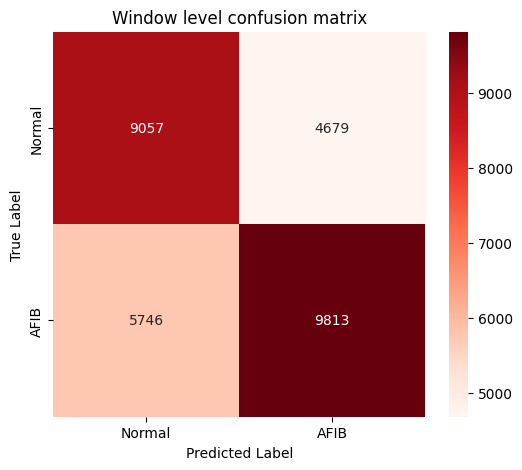

In [24]:
# load best model
model.load_state_dict(torch.load("best_cnn_bigru_attention.pth"))
model.eval()

# predictions and GT
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# classification report
print("Window level classification report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'AFIB']))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal','AFIB'], yticklabels=['Normal','AFIB'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Window level confusion matrix')
plt.show()

#### Smoothing function

In [25]:
def smooth_predictions(probs, window_size=9):
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(probs, kernel, mode='same')
    pad = window_size // 2
    smoothed[:pad] = probs[:pad]
    smoothed[-pad:] = probs[-pad:]
    return smoothed

### Evaluate model on patients

In [26]:
# evaluate model on val patients instead of windows
global_true = []
global_pred = []

for patient_id in tqdm(val_patients):
    # load signal
    path = os.path.join(data_dir, patient_id)
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path, 'atr')
    signal = record.p_signal

    # label mask
    label_mask = np.full(len(signal), -1, dtype=int)
    current_label = -1
    for i, (samp, sym) in enumerate(zip(ann.sample, ann.aux_note)):
        if '(AFIB' in sym:
            current_label = 1
        elif '(N' in sym:
            current_label = 0
        else:
            current_label = -1

        end = ann.sample[i+1] if i < len(ann.sample)-1 else len(signal)
        label_mask[samp:end] = current_label

    # slide non-overlapping windows over signal
    windows, labels = [], []
    for start in range(0, len(signal) - WINDOW_SIZE, WINDOW_SIZE):
        end = start + WINDOW_SIZE
        seg_labels = label_mask[start:end]

        if -1 in seg_labels:
            continue

        label = 1 if np.sum(seg_labels) > (WINDOW_SIZE / 2) else 0

        # normalize and reject noise
        seg = signal[start:end]
        seg = (seg - seg.mean(axis=0)) / (seg.std(axis=0) + 1e-6)
        if np.max(np.abs(seg)) > 20:
            continue

        windows.append(seg)
        labels.append(label)

    if len(windows) == 0:
        continue

    # run model
    Xp = np.array(windows, dtype=np.float32).transpose(0, 2, 1)
    Xt = torch.tensor(Xp).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(Xt), dim=1)[:, 1].cpu().numpy()

    # smooth probabilities
    smooth_probs = smooth_predictions(probs, window_size=9)
    preds = (smooth_probs > 0.4).astype(int)

    # collect results
    global_true.extend(labels)
    global_pred.extend(preds)

100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Patient level classification report
              precision    recall  f1-score   support

      Normal       0.61      0.42      0.50      6866
        AFIB       0.60      0.77      0.67      7782

    accuracy                           0.61     14648
   macro avg       0.61      0.59      0.59     14648
weighted avg       0.61      0.61      0.59     14648



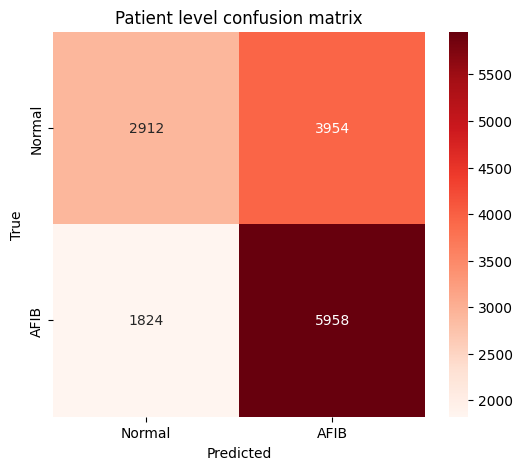

In [27]:
# classification report
print("Patient level classification report")
print(classification_report(global_true, global_pred, target_names=['Normal', 'AFIB']))

# confusion matrix
cm = confusion_matrix(global_true, global_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'AFIB'], yticklabels=['Normal', 'AFIB'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Patient level confusion matrix")
plt.show()
